In [24]:
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_datareader as pdr
import tushare as ts
print(pdr.__version__)

0.4.1


In [97]:
def fetch_yahoo_hisclose(symbol, start, end):
    if hasattr(symbol, "__iter__"):
        quote_panel = pdr.get_data_yahoo(symbol, start=start, end=end)
        quote = quote_panel.to_frame()
        quote = quote['Adj Close'].unstack()[symbol].sort_index()
        quote.columns.name = None
        return quote
    else:
        quote = pdr.get_data_yahoo(symbol, start=start, end=end)["Adj Close"]
        quote.name = symbol
    quote.index.name = "date"
    return quote

def fetch_tushare_hisclose(symbol, start, end, index=False):
    start = start.strftime("%Y-%m-%d")
    end = end.strftime("%Y-%m-%d")
    if hasattr(symbol, "__iter__"):
        quote = pd.DataFrame()
        for sym in symbol:
            a_quote = ts.get_k_data(sym, start, end, index=index)[[
                "date", "close"]].set_index("date")
            print a_quote
            a_quote.columns = [sym]
            quote = pd.concat([quote, a_quote], axis=1)
    else:
        quote = ts.get_k_data(symbol, start, end, index=index)[[
            "date", "close"]].set_index("date")["close"]
        quote.name = symbol
    return quote

def normalize_quote(quote):
    pct_changes = quote.pct_change().fillna(0)
    normalized_quote = (pct_changes + 1).cumprod()
    return normalized_quote

def cal_portfolio_performance(close_s, start, end, year_rf=0.00):
    period = (end - start).days * 250 / 365.0
    rf_daily = year_rf / period
    daily_return = close_s.pct_change()
    mean = daily_return.mean()
    std = daily_return.std(ddof=0)
    sharpe = (mean - rf_daily) / std * np.sqrt(period)
    cum_return = close_s[-1] / close_s[0] - 1
    return {"daily_mean": mean, "daily_std": std, 
            "cum_return": cum_return, "sharpe": sharpe}

def cal_portfolio_close(normalized_quote, allocations):
    portfolio_quote = normalized_quote * allocations
    portfolio_quote = portfolio_quote.sum(axis=1)
    portfolio_quote.name = "portfolio"
    return portfolio_quote

{'cum_return': 0.0035103115401491358,
 'daily_mean': 8.6517097819685767e-05,
 'daily_std': 0.011964437592289644,
 'sharpe': 0.11433512170856555}

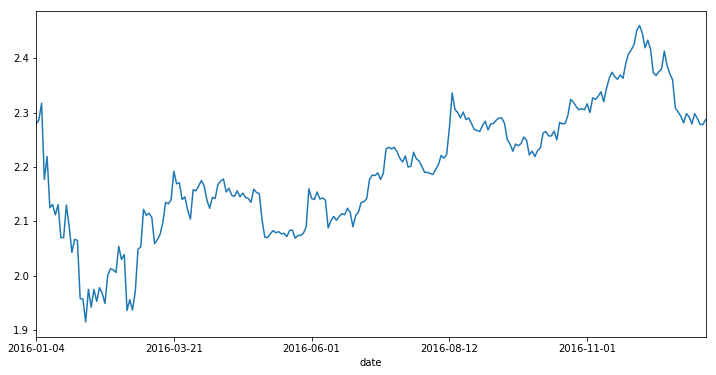

In [102]:
start = date(2016, 1, 1)
end = date(2016, 12, 31)

# symbols = ['C', 'GS', 'IBM', 'HNZ']

quote = fetch_tushare_hisclose("510050", start, end)
# quote = fetch_yahoo_hisclose("SPY", start, end)
quote.plot(figsize=(12, 6))
cal_portfolio_performance(quote, start, end)

In [15]:
def simulate(start, end, symbols, allocations):
    quote = fetch_multisymbol_close(start, end, symbols)
    normalized_quote = normalize_quote(quote)
    portfolio_quote = cal_portfolio_close(
        normalized_quote, allocations)
    return cal_portfolio_performance(portfolio_quote)

def plot_portfolio(start, end, symbols, allocations, benchmark_hisclose):
    quote = fetch_multisymbol_close(start, end, symbols)
    normalized_quote = normalize_quote(quote)
    portfolio_quote = cal_portfolio_close(
        normalized_quote, allocations)
    portfolio_quote.plot(legend=True)

    benchmark_quote = pdr.get_data_yahoo("SPY", start=start, end=end)["Adj Close"]
    benchmark_quote.name = "SPY"
    normalized_bm_quote = normalize_quote(benchmark_quote)
    normalized_bm_quote.plot(legend=True)
    
def find_optimal_portfolio(normalized_quote):
    backtest = {}
    for i in xrange(11):
        r1 = 10 - i
        for j in xrange(r1):
            r2 = r1 - j
            for k in xrange(r2):
                l = r2 - k
                key = (i, j, k, l)
                portfolio_quote = cal_portfolio_close(normalized_quote, key)
                _,_,sharpe,_ = cal_portfolio_performance(portfolio_quote)
                backtest[key] = sharpe
    for k,v in backtest.items():
        if v == max(backtest.values()):
            return k, v

# backtest

In [22]:
start = "20100101"
end = "20101231"
symbols = ['C', 'GS', 'IBM', 'HNZ']
quote = fetch_multisymbol_close(start, end, symbols)
normalized_quote = normalize_quote(quote)

minor               C          GS         IBM        HNZ
Date                                                    
2010-01-04  33.279453  156.910156  110.327240  42.840000
2010-01-05  34.551903  159.684326  108.994499  42.619999
2010-01-06  35.628586  157.979965  108.286469  42.630001
2010-01-07  35.726463  161.071381  107.911644  42.570000
2010-01-08  35.139191  158.025284  108.994499  42.410000


In [16]:
optimal, sharpe = find_optimal_portfolio(normalized_quote)
optimal = [o / 10.0 for o in optimal]

In [17]:
optimal

[0.3, 0.0, 0.0, 0.7]

(0.00088787255137552277,
 0.011797441186886835,
 1.1899612338870351,
 1.2268627416058497)

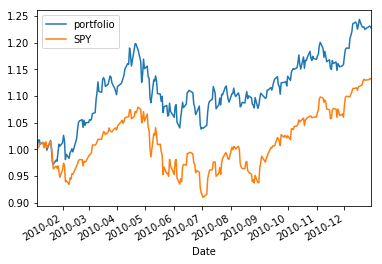

In [18]:
plot_portfolio(start, end, symbols, optimal)
simulate(start, end, symbols, optimal)

# stock in china

In [19]:
import tushare as ts
# benchmark = ts.get_k_data("000016", index=True, start="2016-01-01", end="2016-12-31")["close"]
    
def fetch_multisymbol_close(start, end, symbols):
    result = pd.DataFrame()
    for symbol in symbols:
        quote = ts.get_k_data(symbol, start, end)[["date", "close"]].set_index("date")
        quote.columns = [symbol]
        result = pd.concat([result, quote], axis=1)
    return result

quote = fetch_multisymbol_close(
    start="2016-07-01", end="2017-6-30", symbols=["600000", "600036", "601998", "601318"])
normalized_quote = normalize_quote(quote)

In [20]:
optimal, sharpe = find_optimal_portfolio(normalized_quote)
optimal = [o / 10.0 for o in optimal]

((0, 3, 0, 7), 2.627087759166725)

In [128]:
plot_portfolio(start, end, symbols, optimal)
simulate(start, end, symbols, optimal)

,time,price,change,volume,amount,type
0,15:00:00,6.05,--,8,4840,卖盘
1,14:59:55,6.05,--,50,30250,卖盘
2,14:59:35,6.05,--,20,12100,卖盘
3,14:59:30,6.05,-0.01,165,99825,卖盘
4,14:59:20,6.06,0.01,4,2424,买盘
5,14:59:05,6.05,-0.01,2,1210,卖盘
6,14:58:55,6.06,--,4,2424,买盘
7,14:58:45,6.06,--,2,1212,买盘
8,14:58:35,6.06,0.01,2,1212,买盘
9,14:58:25,6.05,-0.01,20,12100,卖盘
